# Visible Target Size x Behavioral Data

The original idea was to quantify the canonical size of objects in the SUN-RGBD database, however the large variation in occlusion complicates this goal. The complete, not perceived, real-world size of the objects is not known and cannot be derived within a good enough margin of error within this database. Instead, the distribution of objects under occlusion conditions can be ascertained. Specifically, objects can be rank ordered in the amount of visibility they have in the scene so we can understand how unlikely it is to see exemplars of an object at certain sizes. For every target object, we will derive a percentile score so we can find out how much bigger or smaller any particular target object is compared to the whole distirbution. Essentially, the visible size of each target object is calculated and regressed against the behavioral data.

In [3]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats
from string import ascii_letters
import seaborn as sns
import json 
from scipy.spatial.transform import Rotation as R

In [4]:
pdir = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_analysis/TAC_data/'

TAC_250 = pd.read_csv(pdir + 'raw_250_data.csv')
TAC_500 = pd.read_csv(pdir + 'raw_500_data.csv')
TAC_750 = pd.read_csv(pdir + 'raw_750_data.csv')
TAC_1000 = pd.read_csv(pdir + 'raw_1000_data.csv')

In [5]:
def trial_pivotTable(data):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each individual target (stimulus) the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    - trial RT 
    """
    
    avg_tables = []
    std_tables = []
    result_tables = []
    cond = 0
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        actual = pd.pivot_table(duration,  values = ["actual_depth"], columns=['stimulus'], aggfunc=np.mean)
        actual.reset_index()
        actual_renamed = actual.rename(index={'actual_depth': 'Actual Depth'})
        
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['stimulus'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        trial_RT = pd.pivot_table(duration, values = ["trial_RT"], columns = ["stimulus"], aggfunc = np.mean)
        trial_RT.reset_index()
        trial_RT_renamed = trial_RT.rename(index={'trial_RT': 'Average Trial RT'})
        
        frames = [avg_renamed, std_renamed, sem_renamed, trial_RT_renamed, actual_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        result = result.sort_values(by=['Actual Depth'])

        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 250
        if cond == 1:
            result["Duration"] = 500
        if cond == 2:
            result["Duration"] = 750
        if cond == 3:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
        
    
    return result_tables

In [6]:
TAC_raw_trial_pivot = trial_pivotTable([TAC_250, TAC_500, TAC_750, TAC_1000])


In [7]:
def trial_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [250, 500, 750, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        actualdepths = [x_250, x_500, x_750, x_1000]
        xs = [list of individual targets]
        ys = [y_250, y_500, y_750, y_100]
        stes = [ste_250, ste_500, ste_750, ste_1000]
        
    """
    xs = []
    ys = []
    stes = []
    stds = []
    actualdepths = []
    RTs = []
    for table in data:
        x = []
        y = []
        ste = []
        std = []
        depths = []
        rts = []
        for idx, row in table.iterrows():
            
            x.append(idx) #idx is the target (stimulus path)
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
            
            depth = row["Actual Depth"]
            depths.append(depth)
            
            standard_deviation = row["Standard Deviation"]
            std.append(standard_deviation)  
            
            trial_RT = row['Average Trial RT']
            rts.append(trial_RT)
            
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        actualdepths.append(depths)
        stds.append(std)
        RTs.append(rts)

    return xs, ys, stes, actualdepths, stds, RTs


In [8]:
TAC_trial_raw_final = trial_getxy(TAC_raw_trial_pivot)



In [11]:
TAC_trial_plot_data = TAC_trial_raw_final

## Execute this cell to prep for plotting
TAC_final_x_250 = TAC_trial_plot_data[0][0]
TAC_final_y_250 = TAC_trial_plot_data[1][0]
TAC_ste_250 = TAC_trial_plot_data[2][0]
TAC_stim_250 = TAC_trial_plot_data[3][0]
TAC_std_250 = TAC_trial_plot_data[4][0]
TAC_RT_250 = TAC_trial_plot_data[5][0]
TAC_stimfolder_250 = [elem.split('/')[1][:-2] for elem in TAC_final_x_250]


TAC_final_x_500 = TAC_trial_plot_data[0][1]
TAC_final_y_500 = TAC_trial_plot_data[1][1]
TAC_ste_500 = TAC_trial_plot_data[2][1]
TAC_stim_500 = TAC_trial_plot_data[3][1]
TAC_std_500 = TAC_trial_plot_data[4][1]
TAC_RT_500 = TAC_trial_plot_data[5][1]
TAC_stimfolder_500 = [elem.split('/')[1][:-2] for elem in TAC_final_x_500]



TAC_final_x_750 = TAC_trial_plot_data[0][2]
TAC_final_y_750 = TAC_trial_plot_data[1][2]
TAC_ste_750 = TAC_trial_plot_data[2][2]
TAC_stim_750 = TAC_trial_plot_data[3][2]
TAC_std_750 = TAC_trial_plot_data[4][2]
TAC_RT_750 = TAC_trial_plot_data[5][2]
TAC_stimfolder_750 = [elem.split('/')[1][:-2] for elem in TAC_final_x_750]


TAC_final_x_1000 = TAC_trial_plot_data[0][3]
TAC_final_y_1000 = TAC_trial_plot_data[1][3]
TAC_ste_1000 = TAC_trial_plot_data[2][3]
TAC_stim_1000 = TAC_trial_plot_data[3][3]
TAC_std_1000 = TAC_trial_plot_data[4][3]
TAC_RT_1000 = TAC_trial_plot_data[5][3]
TAC_stimfolder_1000 = [elem.split('/')[1][:-2] for elem in TAC_final_x_1000]

In [13]:
_dir = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_analysis'

residuals_250 = np.load(_dir + '/TAC_npy_files/TAC_raw_individual_trial_residuals/residuals_250.npy')
residuals_500 = np.load(_dir + '/TAC_npy_files/TAC_raw_individual_trial_residuals/residuals_500.npy')
residuals_750 = np.load(_dir + '/TAC_npy_files/TAC_raw_individual_trial_residuals/residuals_750.npy')
residuals_1000 = np.load(_dir + '/TAC_npy_files/TAC_raw_individual_trial_residuals/residuals_1000.npy')




### Get visible size of target objects

Notes:
- percentile score for the objects (what percent of the distribution is the object bigger than?) 
- compare against the residuals 
- above 50 is larger than avg size 
- x axis: could subtract 50 from it - bigger or smaller than the average thing 

In [107]:
updated_dirs_path = '/Users/prachimahableshwarkar/Documents/GW/SUNRGBD/updated/kinect2data_192'
stimuli_path = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_stimuli'

In [108]:
c = 0
targetSize_dict = {}
for stim_folder in os.listdir(stimuli_path):
    if stim_folder != '.DS_Store':
        data_path = stimuli_path + '/' + stim_folder + '/data.json'
        data = json.load(open(data_path))
        name_dbID = data['objects'][0]['name'] + '_' + str(data['objects'][0]['dbID'])
                
        annotation2dfinal_path = stim_folder[:-2] + '/annotation2Dfinal'
        for file in os.listdir(updated_dirs_path + '/' + annotation2dfinal_path):
            if 'objSA' in file:
                SA_dict = json.load(open(updated_dirs_path + '/' + annotation2dfinal_path + '/' + file))
                try:
                    targetSize_dict[stim_folder[:-2]] = SA_dict[name_dbID]
                except:
                    pass
                try:
                    targetSize_dict[stim_folder[:-2]] = SA_dict[name_dbID.capitalize()]
                except:
                    pass
                

In [116]:
# Folders that do not have an SA dictionary 
missing_data = []

for stim_folder in os.listdir(stimuli_path):
    if stim_folder[:-2] not in list(targetSize_dict.keys()):
        if 'resize' in stim_folder:
            missing_data.append(stim_folder[:-2])
            annotation2dfinal_path = stim_folder[:-2] + '/annotation2Dfinal'
            filecount = 0
            for file in os.listdir(updated_dirs_path + '/' + annotation2dfinal_path):
                filecount += 1
                if 'objSA' in file:
                    SA_dict = json.load(open(updated_dirs_path + '/' + annotation2dfinal_path + '/' + file))
                    print(SA_dict)
            if filecount != 4:
                print(stim_folder)

len(missing_data)

001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5
000009_2014-05-26_14-32-05_260595134347_rgbf000034-resize_3
002570_2014-06-24_13-59-54_094959634447_rgbf000059-resize_0
002988_2014-06-15_12-24-20_094959634447_rgbf000150-resize_1
002949_2014-06-26_15-57-42_094959634447_rgbf000079-resize_1
{'Floor_25': 0.18848524112463327, 'Chair_1': 2.224668593786486, 'Chair_4': 1.9447849196756508, 'LoungeChair_6': 2.29496601274176, 'Cabinet_9': 4.0047799362955825, 'Table_10': 2.687083121195838, 'Door_13': 1.4506398807964855, 'Door_14': 3.9672600580077515, 'Wall_15': 4.659717240088337, 'Chair_20': 0.3044615637501351, 'Chair_21': 2.8984116587976736, 'Chair_22': 0.6780701235714641, 'Counter_23': 6.304750368337151, 'WritingBoard_32': 4.850115266007511, 'Chair_35': 0.6765010626574086, 'wall_37': 4.033867076340599, 'door_38': 1.0109370832533509, 'puzzle_39': 0.0725155486354277, 'sofa_40': 7.1766318589602545, 'picure_42': 0.0022340781355810226, 'picture_49': 0.00015413118873577777, 'picture_50': 0.

65

In [117]:
# extract target size in the same stimulus order as the TAC data

c = 0
target_size = []
for folder in TAC_stimfolder_250:
    try:
        size = targetSize_dict[folder]
        target_size.append(size)
    except:
        c += 1
        target_size.append(None)

len(target_size), c

(192, 65)

In [129]:
# exclude values that have None and exclude the corresponding TAC data 

final_target_size = []

_filtered_stim = []
_filtered_actualdepth = []
_filtered_y_250 = []
_filtered_y_500 = []
_filtered_y_750 = []
_filtered_y_1000 = []

_filtered_resid_250 = []
_filtered_resid_500 = []
_filtered_resid_750 = []
_filtered_resid_1000 = []

for i in range(len(target_size)):
    if target_size[i] != None:
        if target_size[i] < 30:
            final_target_size.append(target_size[i])

            _filtered_stim.append(TAC_final_x_250[i])
            _filtered_actualdepth.append(TAC_stim_250[i])
            _filtered_y_250.append(TAC_final_y_250[i])
            _filtered_y_500.append(TAC_final_y_500[i])
            _filtered_y_750.append(TAC_final_y_750[i])
            _filtered_y_1000.append(TAC_final_y_1000[i])

            _filtered_resid_250.append(residuals_250[i])
            _filtered_resid_500.append(residuals_500[i])
            _filtered_resid_750.append(residuals_750[i])
            _filtered_resid_1000.append(residuals_1000[i])
        

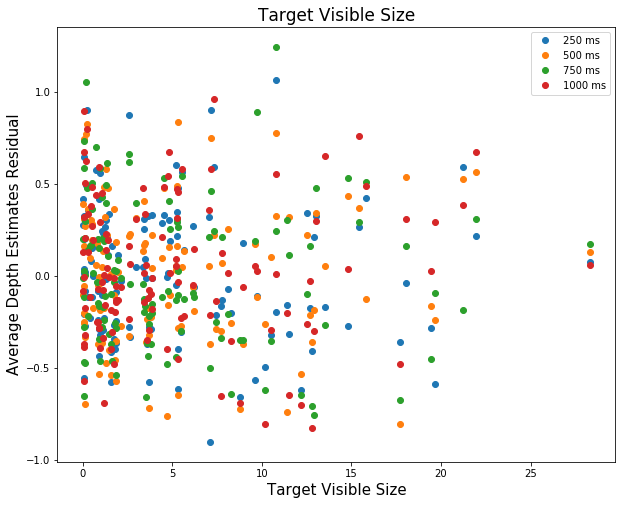

(-0.0789119528619047, 0.38365237787936396)
(0.04087604888119237, 0.6521661404387442)
(-0.05832478433779343, 0.5199336517808433)
(0.025134194395433927, 0.7817096535563547)


In [130]:
plt.figure(figsize=[10,8])
plt.plot(np.array(final_target_size), np.array(_filtered_resid_250), 'o', label='250 ms')
plt.plot(np.array(final_target_size), np.array(_filtered_resid_500), 'o', label='500 ms')
plt.plot(np.array(final_target_size), np.array(_filtered_resid_750), 'o', label='750 ms')
plt.plot(np.array(final_target_size), np.array(_filtered_resid_1000), 'o', label='1000 ms')

plt.xlabel('Target Visible Size', fontsize=15)
plt.ylabel('Average Depth Estimates Residual', fontsize=15)
plt.legend()
plt.title('Target Visible Size', fontsize=17)
plt.show();

print(stats.pearsonr(final_target_size, _filtered_resid_250))
print(stats.pearsonr(final_target_size, _filtered_resid_500))
print(stats.pearsonr(final_target_size, _filtered_resid_750))
print(stats.pearsonr(final_target_size, _filtered_resid_1000))

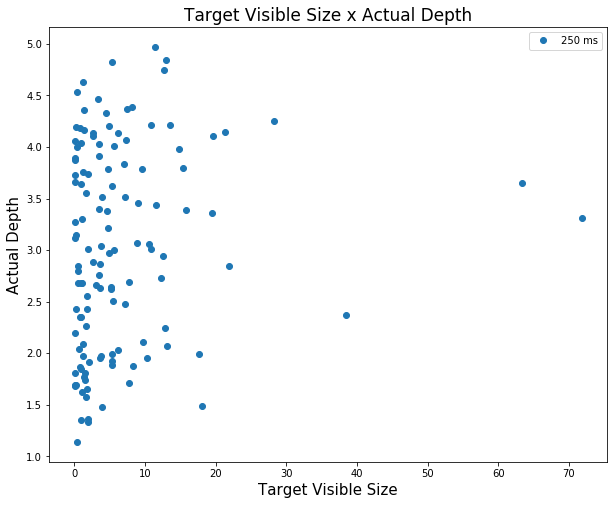

(0.1444845270672806, 0.10508744423944143)


In [124]:
plt.figure(figsize=[10,8])
plt.plot(np.array(final_target_size), np.array(_filtered_actualdepth), 'o', label='250 ms')


plt.xlabel('Target Visible Size', fontsize=15)
plt.ylabel('Actual Depth', fontsize=15)
plt.legend()
plt.title('Target Visible Size x Actual Depth', fontsize=17)
plt.show();

print(stats.pearsonr(final_target_size, _filtered_actualdepth))
